[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)




#Connection to the drive and loading of libraries.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install snntorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.0 MB/s eta 0:00:00


In [ ]:
!pip install neurobench --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-stubs 2.1.4.231227 requires numpy>=1.26.0; python_version < "3.13", but you have numpy 1.24.4 which is incompatible.


In [ ]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import statistics
import tqdm

import scipy.io as sio
import os
import requests

In [ ]:
def carica_dataset(train_setting):

  """
  IMPLEMENTARE GT, DATASET NORMALE 1ms
  """

  down1 = ''
  down2 = ''
  if train_setting['down']:
    down1 = '_downsample'
    down2 = '_down'

  gt = ''
  if train_setting['GT']:
    gt = '_gt'

  if train_setting['dataset'] == 'Brochier':
    path = '/content/drive/MyDrive/Dataset/' + train_setting['dataset'] + '/Potential'
    path = path + '/brochier_monkey_i_' + train_setting['binning'] + '_bins'
    var_dict = 'dataset' + down1

  if train_setting['dataset'] == 'Sabes':
    path = '/content/drive/MyDrive/Dataset/' + train_setting['dataset'] + '/Potential'
    if train_setting['sabes_len'] == 'broadband':
      path = path + '/sabes_broadband' + train_setting['traccia_sabes'] + '_' + train_setting['binning'] + train_setting['prova']
      var_dict = 'broadband_dataset'
    else:
      path = path + '/sabes_len' + str(train_setting['sabes_len']) +  train_setting['traccia_sabes'] + train_setting['windowing'] + train_setting['prova']
      var_dict = 'windowed_dataset'


  # neural_chunks
  mat_contents = sio.loadmat(path)
  neural_chunks = mat_contents[var_dict][0,0]['neural_chunks' + gt]




  if train_setting['dataset'] == 'Brochier':
    vel = mat_contents[var_dict][0,0]['vel_chunks_padded'+ down2]
    f1  = mat_contents[var_dict][0,0]['f1_chunks_padded' + down2]
    f2  = mat_contents[var_dict][0,0]['f2_chunks_padded' + down2]
    f3  = mat_contents[var_dict][0,0]['f3_chunks_padded' + down2]
    f4  = mat_contents[var_dict][0,0]['f4_chunks_padded' + down2]
    uscite = np.array([vel, f1, f2, f3, f4])
    uscite = np.transpose(uscite, [1, 0, 2])

  elif train_setting['dataset'] == 'Sabes':
    uscite = mat_contents[var_dict][0,0][train_setting['target']]

  if train_setting['only_one']:
    uscite = uscite[:, train_setting['variabile_selezionata']:train_setting['variabile_selezionata']+1, :]

  return path, mat_contents, var_dict, neural_chunks, uscite


def prepare_dataset_kcross(train_setting, k, neural_chunks, uscite):
  if train_setting['k_cross_validation'][0]:
    partizionamenti = train_setting['k_cross_validation'][1]
    finestre4partizionamento = int(np.floor(len(neural_chunks)/partizionamenti))
    dataset_input =  []
    dataset_output = []

    for i in range(partizionamenti):
      i_min = i * finestre4partizionamento
      i_max = (i+1) * finestre4partizionamento

      dataset_input_i  = neural_chunks[i_min:i_max,:,:]
      dataset_output_i = uscite[i_min:i_max,:,:]

      dataset_input.append(dataset_input_i)
      dataset_output.append(dataset_output_i)

    test_input  = dataset_input.pop(k)
    test_output = dataset_output.pop(k)

    training_input  = np.vstack(dataset_input)
    training_output = np.vstack(dataset_output)

  return training_input, training_output, test_input, test_output


def estrai_dict(test_path, train_setting):

  with open(test_path + '/0parametri_training.txt', 'r') as file:
      next(file)  # Skip the first line
      for line in file:
          key, value = line.strip().split(' = ')
          if value.isdigit():  # if the value is a number, convert it
              value = int(value)
          elif value.replace('.', '', 1).isdigit() and value.count('.') < 2:  # if the value is a float, convert it
              value = float(value)
          elif value == 'True':  # if the value is the boolean True
              value = True
          elif value == 'False':  # if the value is the boolean False
              value = False
          elif value.startswith('[') and value.endswith(']'):  # if the value is a list, parse it
              value = value.strip('[]').split(',')  # Remove the brackets and split the string by commas
              value = [int(v.strip()) if v.strip().isdigit() else float(v.strip()) if v.strip().replace('.', '', 1).isdigit() else v.strip() for v in value]
          train_setting[key] = value

  return train_setting


import numpy as np

def CC(gt, inference):
  return np.corrcoef(gt, inference)[0, 1]

def FAV(gt, inference):
  num = np.var(gt - inference)
  var_GT = np.var(gt)
  return 1 - num/var_GT

def Rsquare(gt, inference):
    num = np.square(gt - inference)
    den = np.square(gt - np.mean(gt))
    return 1 - np.sum(num)/np.sum(den)

def MSE(gt, inference):
  error = gt - inference
  square_error = (error)**2
  return np.mean(square_error)

def RMSE(gt, inference):
  mse = MSE(gt, inference)
  return np.sqrt(mse)


def accuracy_evaluation_no_filt(trained_output, test_output):
  txt = ''
  test_entries = test_output.shape[0]
  n_last = test_output.shape[1]
  metriche_utilizzate = ['CC', 'FAV', 'R^2', 'MSE','RMSE']
  results = np.zeros((len(metriche_utilizzate), test_entries, n_last))

  for metrica in metriche_utilizzate:
    for j in range(n_last):
      for i in range(test_entries):
        if metrica == 'CC':
          results[0, i, j] = CC(test_output[i, j], trained_output[i, j])

        elif metrica == 'FAV':
          results[1, i, j] = FAV(test_output[i, j], trained_output[i, j])

        elif metrica == 'R^2':
          results[2, i, j] = Rsquare(test_output[i, j], trained_output[i, j])

        elif metrica == 'MSE':
          results[3, i, j] = MSE(test_output[i, j], trained_output[i, j])

        elif metrica == 'RMSE':
          results[4, i, j] = RMSE(test_output[i, j], trained_output[i, j])

  for i, metrica in enumerate(metriche_utilizzate):
    txt = txt + metrica + ' ['
    for j in range(n_last):
      txt = txt + str(round(results[i,:,j].mean(), 2))  + ', '
    txt = txt + '] \n'

  return results, txt

def accuracy_evaluation_filt(trained_output, test_output, soglia):
  samples = test_output.shape[0]
  n_last =  test_output.shape[1]

  txt = ''
  metriche_utilizzate = ['CC', 'FAV', 'R^2', 'MSE','RMSE']

  for metrica in metriche_utilizzate:

    txt = txt +  metrica + ': ['

    for j in range(n_last):
      metric_evaluation = []
      for i in range(samples):

        if np.max(test_output[i, j]) > soglia:

          if metrica == 'CC':
            metric_evaluation.append(np.corrcoef(trained_output[i, j], test_output[i, j])[0, 1])

          elif metrica == 'FAV':
            metric_evaluation.append(FAV(test_output[i, j], trained_output[i, j]))

          elif metrica == 'R^2':
            metric_evaluation.append(Rsquare(test_output[i, j], trained_output[i, j]))

          elif metrica == 'MSE':
            metric_evaluation.append(np.mean((trained_output[i, j] - test_output[i, j])**2))

          elif metrica == 'RMSE':
            metric_evaluation.append(np.sqrt(np.mean((trained_output[i, j] - test_output[i, j])**2)))

      metric_evaluation = np.array(metric_evaluation)
      mean_value = np.mean(metric_evaluation)

      txt = txt + '{:.2f}, '.format(mean_value)

    txt = txt + '] \n'

  return txt


def pol_var2pol(pol_var, pol_gt):
  pol = np.cumsum(pol_var, axis=2)/400
  for i in range(len(pol_var)):
    for j in range(2):
      pol[i,j,:] = pol[i,j,:] + pol_gt[i,j,0]
  return pol

def pol2cart(polar):
  teta = polar[:, 0, :]
  r    = polar[:, 1, :]
  x = r * np.cos(teta)
  y = r * np.sin(teta)
  tmp = np.array([x, y])
  return np.transpose(tmp, [1, 0, 2])

def polvar2cart(pol_var, pol_gt):
  pol = pol_var2pol(pol_var, pol_gt)
  return pol2cart(pol)


def calcola_len_window(reaches, n_rch_train):
  target_training_n = reaches[::n_rch_train]
  return int(np.mean(np.diff(target_training_n)))


#shape in ingressso LEN x CHN
def format_broadband(spike, vel, reaches, n_rch_train, len_window):
  target_training_n = reaches[::n_rch_train]
  target_training_n = target_training_n - target_training_n[0]
  len_broad = len(spike)

  n_window = 0
  for start in target_training_n:
    if start + len_window < len_broad:
      n_window = n_window + 1

  spike = np.transpose(spike, (1, 0))
  vel   = np.transpose(vel, (1, 0))

  spike_w = np.zeros((n_window, 96, len_window))
  vel_w   = np.zeros((n_window,  2, len_window))

  for i, start in enumerate(target_training_n):
    if start + len_window > len_broad:
      break
    spike_w[i,:,:] = spike[:, start:start + len_window]
    vel_w[i,:,:]   =   vel[:, start:start + len_window]


  for finestra in range(n_window):
    start_broadband = target_training_n[finestra]
    check1 = spike_w[finestra, :,:] - spike[:, start_broadband:start_broadband+len_window]
    check2 =   vel_w[finestra, :,:] -   vel[:, start_broadband:start_broadband+len_window]

    if np.max(check1)> 0 or np.max(check2)> 0:
      print("errore")
      break

  return spike_w, vel_w

#Training setting

In [ ]:
train_setting = {

    'dataset': 'Sabes',                       #Brochier; Sabes
    'GT'     : False,                          #utilizzare la spike detection del dataset
    'down'   : False,
    'binning': '1ms',                         #1ms; 2ms; 4ms; 8ms;

    'sabes_len': 'broadband',                 #lunghezza finestra Sabes in termini di variazioni del target/numero campioni
    'traccia_sabes' : '_' + '20170131_02',    #20170127_03 , 20170124_01, 20170131_02, 20160630_01,  20160622_01
    'windowing': '',                          #target; truncated;
    'target' : 'vel',                         #pos; vel; pol; pol_var; pol_prof
    'prova' : '_thr5.mat',                    #modifiche al dataset;

    'k_cross_validation': (False, 5),
    'shuffle_training': False,

    'only_one' : False,                       # training fatto solo su una sola variabile (se sono presenti più variabili nel dataset)
    'variabile_selezionata' : 0,              # selezione variabile per il training su un'unica variabile
    'soglia': 50,                             # selezione soglia per eliminare le finestre rumorose dal calcolo dell'accuratezza (BROCHIER)

    'decay_train'     :True,                  #True: voltage decay trained;
    'thr_train'       :False,                 #True: threshold trained;
    'bias'            :False,                 #True: inserimento di un bias in ogni neurone

    '1beta4layer'     :False,                 #True: un solo valore di decay per layer
    'beta_out_single' :False,                 #True: un solo valore di decay per i neuroni dell'ultimo layer
    '1thr4layer'      :True,                  #True: un solo valore di threshold per layer

    'lr' : 1e-3,                              #learning rate

    'epochs': 100,                            #epoche
    'batch': 10,                              #batch size
    'training_ratio' : [0.8, 0.1],            #NEUROBENCH 0.5, 0.25 oppure 0.8, 0.1

    'hyperparams': [64, 128, 64],             #rete implementata 3 layer
    'thr_init' : 0.1,                         #threshold costante
    'bet_init': 0.9,                          #beta decay costante

    'reset': "subtract",                      #none; subtract; zero; meccanismo di reset dei neuroni
}

TRAINING = False

#Loading dataset
To ensure the script works, it is enough to have a dataset formatted in the following way:
training_input [window_index, input_variables, window_length], training_output [window_index, output_variables, window_length]. The same goes for test_output and test_input.

/content/drive/MyDrive/Dataset/Sabes/Potential/sabes_broadband_20170131_02_1ms_thr5.mat
numero totale di reaches : 635

reaches training : 508
reaches validation : 64
reaches test : 63

Training   window : 0:656840
Validation window : 656840:740743
Test       window : 740743:830052

numero totale di campioni training : 656840
numero totale di campioni validation : 83903
numero totale di campioni testing  : 89309

training_input (169, 96, 3876)
training_output (169, 2, 3876)

validation_input (21, 96, 3876)
validation_output (21, 2, 3876)

test_input (89309, 96)
test_output (89309, 2)


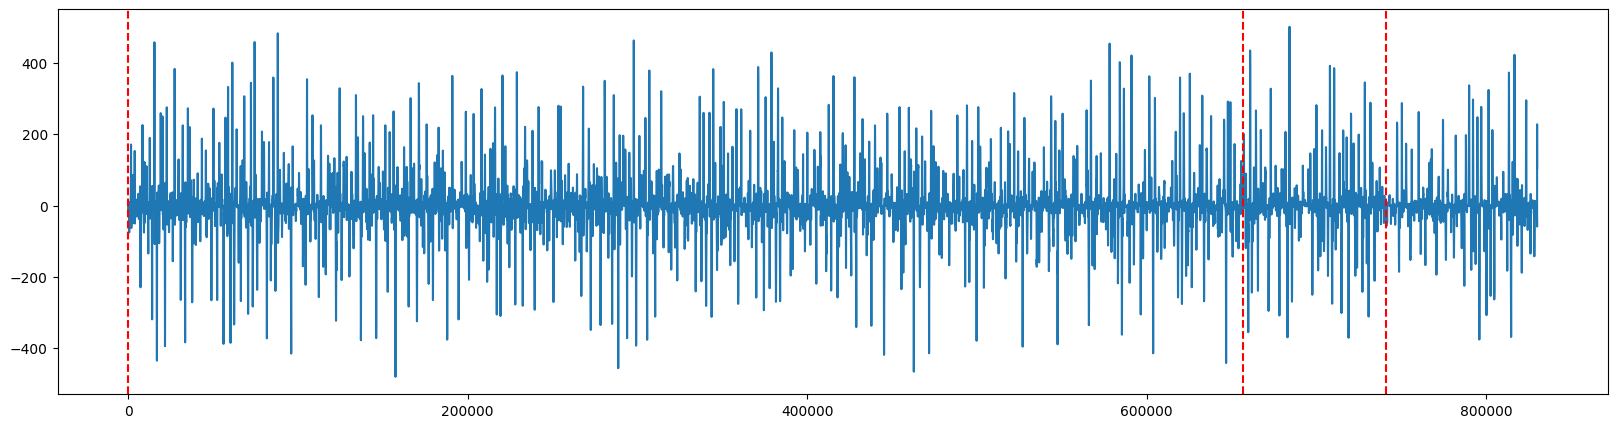

In [ ]:
TRAINING_FINESTRE = True


training_ratio = [0.8, 0.1, 0.1]

path, mat_contents, var_dict, neural_chunks, uscite = carica_dataset(train_setting)
neural_chunks = np.transpose(neural_chunks, (1,0))


target = mat_contents[var_dict][0,0]['index_var_targets']
target = target.squeeze()

start_reach = 0
start       = 0

#Numero di reaches per partizionamento
training_reaches   = int(len(target)*training_ratio[0])
validation_reaches = int(round(len(target)*training_ratio[1]))
test_reaches       = int(len(target) - validation_reaches - training_reaches)

#Indice dove si verifica i-esimo reach
training_entries   = int(target[training_reaches])
validation_entries = int(target[training_reaches + validation_reaches])

print(path)

print("numero totale di reaches : {}".format(len(target)))
print("\nreaches training : {}".format(training_reaches -start_reach))
print("reaches validation : {}".format(validation_reaches))
print("reaches test : {}".format(len(target) - training_reaches - validation_reaches))


print("\nTraining   window : {}:{}".format(start, training_entries))
print("Validation window : {}:{}".format(training_entries, validation_entries))
print("Test       window : {}:{}".format(validation_entries, len(uscite)))

training_input   = neural_chunks[start:training_entries, :]
validation_input = neural_chunks[training_entries: validation_entries, :]
test_input       = neural_chunks[validation_entries:, :]

training_output = uscite[start:training_entries, :]
validation_output = uscite[training_entries: validation_entries, :]
test_output = uscite[validation_entries:, :]

print(f"\nnumero totale di campioni training : {training_input.shape[0]}")
print(f"numero totale di campioni validation : {validation_input.shape[0]}")
print(f"numero totale di campioni testing  : {test_input.shape[0]}\n")

if TRAINING_FINESTRE:
  n_reac = 3
  len_window = calcola_len_window(target[0:training_reaches], n_reac)
  training_input, training_output     = format_broadband(training_input, training_output, target[start_reach:training_reaches], n_reac, len_window)
  validation_input, validation_output = format_broadband(validation_input, validation_output, target[training_reaches:training_reaches + validation_reaches], n_reac, len_window)

print(f"training_input {training_input.shape}")
print(f"training_output {training_output.shape}\n")

print(f"validation_input {validation_input.shape}")
print(f"validation_output {validation_output.shape}\n")

print(f"test_input {test_input.shape}")
print(f"test_output {test_output.shape}")

plt.figure(figsize = (20, 5))
plt.plot(uscite[:, 0])
plt.axvline(x=start, color='r', linestyle='--')
plt.axvline(x=training_entries, color='r', linestyle='--')
plt.axvline(x=validation_entries, color='r', linestyle='--')

#Saving train setting

In [ ]:
import datetime
data = str(datetime.datetime.now())
data = ((data[0:16].replace(" ", "_")).replace("-","_")).replace(":","_")

if train_setting['dataset'] == 'Brochier':
  trained_dataset = 'Brochier/snnTorch/monkey-i/'
elif train_setting['dataset'] == 'Sabes':
  trained_dataset = 'Sabes/snnTorch/'

trained_folder = '/content/drive/MyDrive/Trained-potential/' + trained_dataset + '/potential' + data

if train_setting['k_cross_validation'][0]:
  trained_folder = path_key + '/' + 'k_' + str(k)

os.makedirs(trained_folder, exist_ok=True)

with open(trained_folder + "/0parametri_training.txt", "w") as f_save:
  f_save.write(path + '\n')
  for chiave in train_setting:
    f_save.write("{} = {} \n".format(chiave, train_setting[chiave]))

if train_setting['shuffle_training']:
  np.save(trained_folder + '/permutation_index.npy', permutation_indices)

#Create Datasets

In [ ]:
class BroadbandDataset(torch.utils.data.Dataset):

    def __init__(self, target, spike_in):
      self.labels   = target
      self.features = spike_in

    def __len__(self):
        """Number of samples."""
        return len(self.labels)

    def __getitem__(self, idx):
        """General implementation, but we only have one sample."""
        batch_feature = self.features[idx, :]
        batch_labels  = self.labels[idx, :]
        return (
            torch.tensor(batch_feature.astype(np.float32)).unsqueeze(0), #.astype(np.float32),
            torch.tensor(batch_labels.astype(np.float32)) #.astype(np.float32)
        )

class RegressionDataset(torch.utils.data.Dataset):

    def __init__(self, target, spike_in):
        self.num_samples = target.shape[0]
        timesteps = target.shape[2]

        target   = target.astype(np.float32)
        spike_in = spike_in.astype(np.float32)

        labels_target = []
        lista = []
        for i in range(self.num_samples):
          target_i = target[i, :, :]
          target_i = np.transpose(target_i, (1, 0))
          labels_target.append(torch.from_numpy(target_i))

          spike_ing = spike_in[i, :, :]
          spike_ing = np.transpose(spike_ing, (1, 0))
          lista.append(torch.from_numpy(spike_ing))

        self.labels   = torch.stack(labels_target, dim=1)
        self.features = torch.stack(lista, dim=1)


    def __len__(self):
        """Number of samples."""
        return self.num_samples

    def __getitem__(self, idx):
        """General implementation, but we only have one sample."""
        return self.features[:, idx, :], self.labels[:, idx, :]


batch_size = train_setting['batch']

if TRAINING_FINESTRE:
  training_dataset = RegressionDataset(target=training_output, spike_in = training_input)
  train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, drop_last=False)
  validation_dataset = RegressionDataset(target=validation_output, spike_in = validation_input)
  validation_loader  =  torch.utils.data.DataLoader(dataset=validation_dataset, batch_size = len(validation_input), drop_last=True)
else:
  training_dataset = BroadbandDataset(target=training_output, spike_in = training_input)
  train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, drop_last=True)
  validation_dataset = BroadbandDataset(target=validation_output, spike_in = validation_input)
  validation_loader  =  torch.utils.data.DataLoader(dataset=validation_dataset, batch_size = batch_size, drop_last=True)

test_dataset = BroadbandDataset(target=test_output, spike_in = test_input)
test_loader =  torch.utils.data.DataLoader(dataset=test_dataset, batch_size = len(test_input), drop_last=False)


for data, target in train_loader:
    print("Dimensioni dei dati:", data.shape)
    print("Dimensioni del target:", target.shape)
    print("Finestre Training :", len(train_loader))
    break  # Uscire dopo il primo batch

Dimensioni dei dati: torch.Size([10, 3876, 96])
Dimensioni del target: torch.Size([10, 3876, 2])
Finestre Training : 17


#Construct Model


In [ ]:
class Net(torch.nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, timesteps, input = 1, target_variables = 1, testing_broad = False):
        super().__init__()

        l0 = train_setting['hyperparams'][0]
        l1 = train_setting['hyperparams'][1]
        l2 = train_setting['hyperparams'][2]

        self.timesteps = timesteps # number of time steps to simulate the network
        self.testing_broad = testing_broad
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function

        if train_setting['1thr4layer']:
          thr_in       = train_setting['thr_init']
          thr_hidden   = train_setting['thr_init']
          thr_hidden2  = train_setting['thr_init']
        else:
          thr_in      = torch.ones(l0)*train_setting['thr_init']
          thr_hidden  = torch.ones(l1)*train_setting['thr_init']
          thr_hidden2 = torch.ones(l2)*train_setting['thr_init']

        if train_setting['1beta4layer']:
          beta_in      = train_setting['bet_init']
          beta_hidden  = train_setting['bet_init']
          beta_hidden2 = train_setting['bet_init']
          beta_out     = train_setting['bet_init']
        else:
          beta_in      = torch.ones(l0)*train_setting['bet_init']
          beta_hidden  = torch.ones(l1)*train_setting['bet_init']
          beta_hidden2 = torch.ones(l2)*train_setting['bet_init']
          beta_out     = torch.ones(target_variables)*train_setting['bet_init']
          if train_setting['beta_out_single']:
            beta_out   = train_setting['bet_init']


        # layer 1
        self.fc_in = torch.nn.Linear(in_features=input, out_features=l0, bias = train_setting['bias'])
        self.lif_in = snn.Leaky(beta=beta_in, threshold=thr_in, learn_beta=train_setting['decay_train'], spike_grad=spike_grad, learn_threshold=train_setting['thr_train'], reset_mechanism=train_setting['reset'])

        # layer 2
        self.fc_hidden = torch.nn.Linear(in_features=l0, out_features=l1, bias = train_setting['bias'])
        self.lif_hidden = snn.Leaky(beta=beta_hidden, threshold=thr_hidden, learn_beta=train_setting['decay_train'], spike_grad=spike_grad, learn_threshold=train_setting['thr_train'], reset_mechanism=train_setting['reset'])

        # layer 3
        self.fc_hidden2 = torch.nn.Linear(in_features=l1, out_features=l2, bias = train_setting['bias'])
        self.lif_hidden2 = snn.Leaky(beta=beta_hidden2, threshold=thr_hidden2, learn_beta=train_setting['decay_train'], spike_grad=spike_grad, learn_threshold=train_setting['thr_train'], reset_mechanism=train_setting['reset'])

        # layer 4: leaky integrator neuron. Note the reset mechanism is disabled and we will disregard output spikes.
        self.fc_out = torch.nn.Linear(in_features=l2, out_features = target_variables, bias = train_setting['bias'])
        self.li_out = snn.Leaky(beta=beta_out, threshold=1.0, learn_beta=train_setting['decay_train'], spike_grad=spike_grad, reset_mechanism="none")


    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem_1 = self.lif_in.init_leaky()
        mem_2 = self.lif_hidden.init_leaky()
        mem_22 = self.lif_hidden2.init_leaky()
        mem_3 = self.li_out.init_leaky()

        # Empty lists to record outputs
        mem_3_rec = []

        # Loop over
        for step in range(self.timesteps):
            x_timestep = x[step, :, :]

            cur_in = self.fc_in(x_timestep)
            spk_in, mem_1 = self.lif_in(cur_in, mem_1)

            cur_hidden = self.fc_hidden(spk_in)
            spk_hidden, mem_2 = self.lif_hidden(cur_hidden, mem_2)

            cur_hidden2 = self.fc_hidden2(spk_hidden)
            spk_hidden2, mem_22 = self.lif_hidden2(cur_hidden2, mem_22)

            cur_out = self.fc_out(spk_hidden2)
            _, mem_3 = self.li_out(cur_out, mem_3)

            mem_3_rec.append(mem_3)

        if self.testing_broad:
          out = torch.stack(mem_3_rec).squeeze()
        else:
          out = torch.stack(mem_3_rec)

        return out

    def Sparsity(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem_1 = self.lif_in.init_leaky()
        mem_2 = self.lif_hidden.init_leaky()
        mem_22 = self.lif_hidden2.init_leaky()
        mem_3 = self.li_out.init_leaky()

        # Empty lists to record outputs
        mem_3_rec = []
        spk1 = np.zeros((64, self.timesteps))
        spk2 = np.zeros((128, self.timesteps))
        spk3 = np.zeros((64, self.timesteps))

        # Loop over
        for step in range(self.timesteps):
            x_timestep = x[step, :, :]

            cur_in = self.fc_in(x_timestep)
            spk_in, mem_1 = self.lif_in(cur_in, mem_1)

            cur_hidden = self.fc_hidden(spk_in)
            spk_hidden, mem_2 = self.lif_hidden(cur_hidden, mem_2)

            cur_hidden2 = self.fc_hidden2(spk_hidden)
            spk_hidden2, mem_22 = self.lif_hidden2(cur_hidden2, mem_22)

            cur_out = self.fc_out(spk_hidden2)
            _, mem_3 = self.li_out(cur_out, mem_3)

            mem_3_rec.append(mem_3)
            spk1[:, step] = spk_in.squeeze()
            spk2[:, step] = spk_hidden.squeeze()
            spk3[:, step] = spk_hidden2.squeeze()

        if self.testing_broad:
          out = torch.stack(mem_3_rec).squeeze()
        else:
          out = torch.stack(mem_3_rec)

        tot_spikes = np.concatenate((spk1.flatten(), spk2.flatten(), spk3.flatten()), axis=0)
        sum_spikes = np.sum(tot_spikes)
        tot_entries = tot_spikes.shape[0]
        sparsity = 1 - sum_spikes/tot_entries

        return sparsity, out, spk1, spk2, spk3

In [ ]:
if train_setting['dataset']=='Brochier':
  n_last = 5
elif train_setting['dataset']=='Sabes':
  n_last = 2
if train_setting['only_one']:
  n_last = 1


if torch.cuda.is_available():
  device = torch.device('cuda')
  print(torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('cpu')

if TRAINING_FINESTRE:
  steps = training_input.shape[2]
else:
  steps = batch_size

model = Net(timesteps=steps, input = 96, target_variables = n_last).to(device)

cpu


#Construct Training Loop

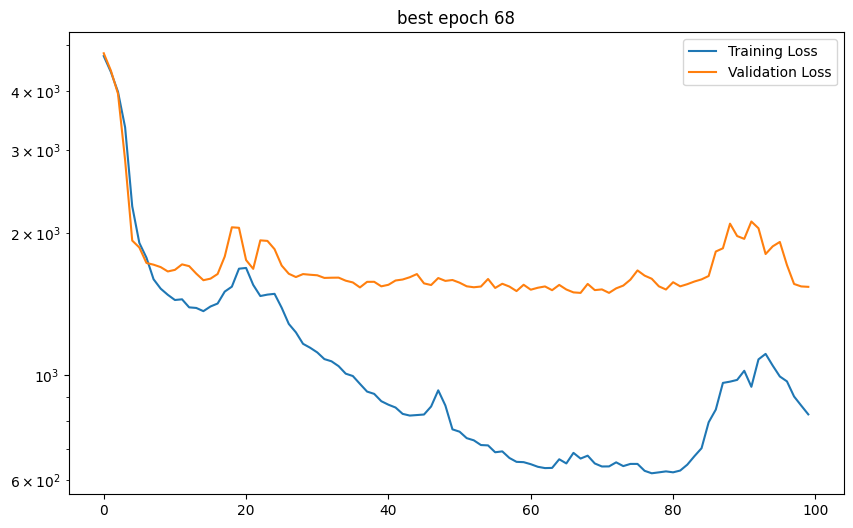

100%|██████████| 100/100 [5:17:45<00:00, 190.65s/it, loss=8.271e+02]


In [ ]:
TRAINING = True

num_iter = train_setting['epochs']
optimizer = torch.optim.Adam(params=model.parameters(), lr=train_setting['lr'])
loss_function = torch.nn.MSELoss()

loss_hist   = []
v_loss_hist = []
v_loss_best = 1e10
epoca = 0

# training loop
with tqdm.trange(num_iter) as pbar:
    for _ in pbar:
        train_batch = iter(train_loader)
        minibatch_counter = 0
        loss_epoch = []

        for feature, label in train_batch:
            # prepare data
            feature = feature.to(device)
            label   = label.to(device)

            if TRAINING_FINESTRE:
              feature =torch.swapaxes(input=feature, axis0=0, axis1=1)
              label   = torch.swapaxes(input=label, axis0=0, axis1=1)

            # forward pass
            mem     = model(feature)

            loss_val = loss_function(mem, label) # calculate loss
            optimizer.zero_grad() # zero out gradients
            loss_val.backward()   # calculate gradients
            optimizer.step()      # update weights

            # store loss
            loss_epoch.append(loss_val.item())
            minibatch_counter += 1

            avg_batch_loss = sum(loss_epoch) / minibatch_counter # calculate average loss p/epoch
            pbar.set_postfix(loss="%.3e" % avg_batch_loss)       # print loss p/batch

        loss_hist.append(avg_batch_loss)
        epoca = epoca + 1
        torch.save(model.state_dict(), trained_folder +  '/network')

        model.eval()
        vloss_sum = 0
        with torch.no_grad():
          for v_feature, v_label in validation_loader:
            if TRAINING_FINESTRE:
              v_feature = torch.swapaxes(input=v_feature, axis0=0, axis1=1)
              v_label   = torch.swapaxes(input=v_label, axis0=0, axis1=1)
            voutputs = model(v_feature)
            vloss_sum += loss_function(voutputs, v_label)
          vloss = vloss_sum.mean()
          v_loss_hist.append(vloss)
          if vloss < v_loss_best:
            best_epoch = epoca
            v_loss_best = vloss
            torch.save(model.state_dict(), trained_folder + '/network_best')


        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.semilogy(loss_hist, label='Training Loss')
        plt.semilogy(v_loss_hist, label = 'Validation Loss')
        plt.title('best epoch {}'.format(best_epoch))
        plt.legend()
        plt.show()

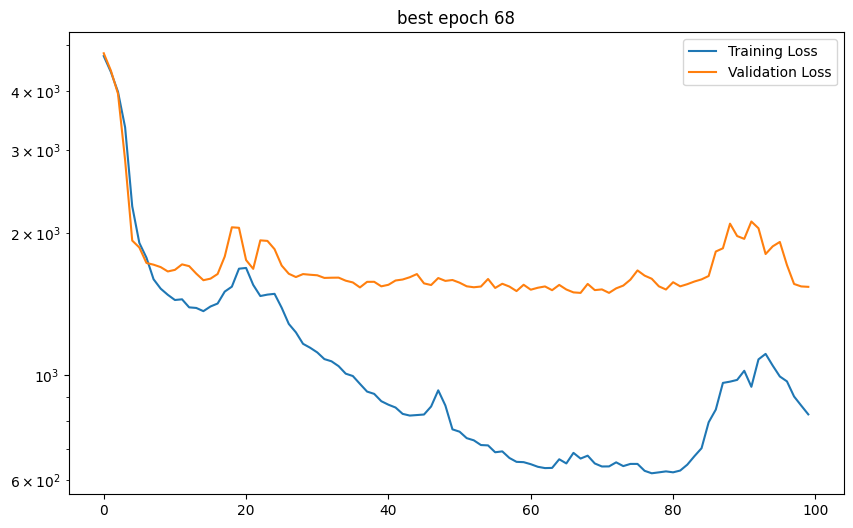

In [ ]:
plt.figure(figsize=(10, 6))
plt.semilogy(loss_hist, label='Training Loss')
plt.semilogy(v_loss_hist, label = 'Validation Loss')
plt.title('best epoch {}'.format(best_epoch))
plt.legend()
plt.savefig(trained_folder + '/loss.png')

#Evaluation

Inferences computing

In [ ]:
model_test = Net(timesteps=len(test_input), input = 96, target_variables = n_last, testing_broad=True).to(device)
model_test.load_state_dict(torch.load(trained_folder + '/network_best'))

<All keys matched successfully>

In [ ]:
inference = []

 # pause gradient calculation during evaluation
with torch.no_grad():

    # loop over data samples
    for feature, label in test_loader:

        # prepare data
        feature = feature.to(device)
        label = label.to(device)

        # forward-pass
        mem = model_test(feature)
        inference.append(mem.detach().squeeze().numpy())

Storing model

In [ ]:
trained_output = np.array(inference).squeeze()

R = []
Cc = []

for i in range(2):
  R.append(Rsquare(test_output[:,i], trained_output[:,i]))
  Cc.append(CC(test_output[:,i], trained_output[:,i]))

print(np.array(R).mean())
print(np.array(Cc).mean())

with open(trained_folder + '/Results.txt', "w") as fw:
  fw.write("R^2 {}".format(np.array(R).mean()))
  fw.write("CC  {}".format(np.array(Cc).mean()))

workload_metrics = ["r2"]
static_metrics = []

model_bench = TorchModel(model_test)
benchmark = Benchmark(model_bench, test_loader, [], [], [static_metrics, workload_metrics])
#results = benchmark.run()
#print(results)
if TRAINING:
  with open(trained_folder + '/Results.txt', "w") as fw:
    #fw.write(str(results))
    fw.write("R^2 {}".format(np.array(R).mean()))
    fw.write("CC  {}".format(np.array(Cc).mean()))

Metrics evaluation

#Plot

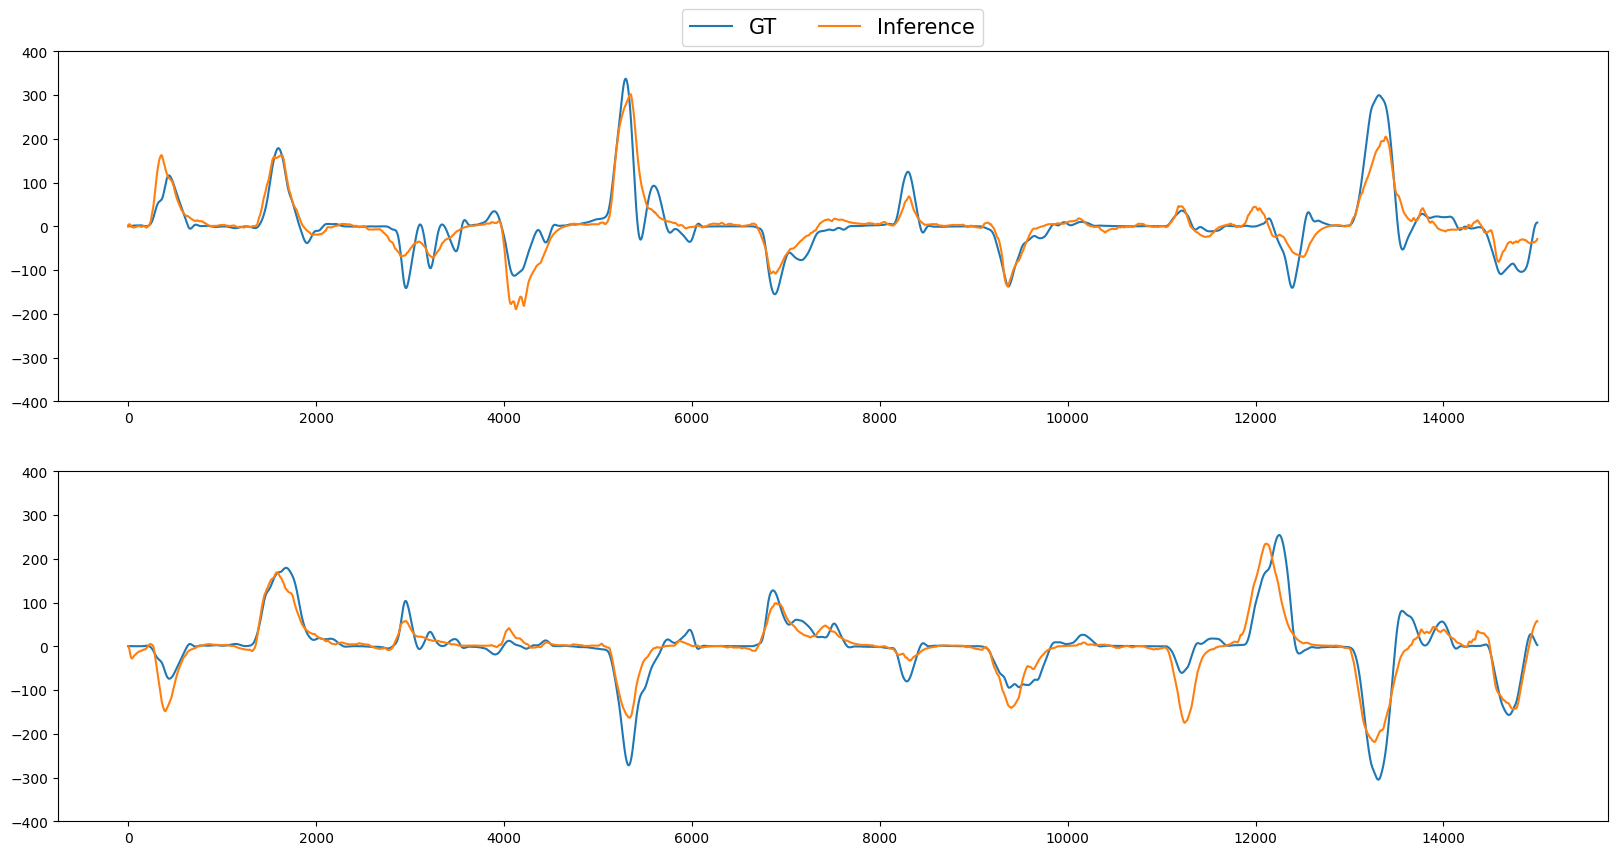

In [ ]:
plt.figure(figsize=(20, 10))

a = 0
b = 15000

for var_out in range(n_last):

  axs = plt.subplot(n_last, 1, var_out + 1)
  axs.plot(test_output[a:b, var_out], label='GT')
  axs.plot(trained_output[a:b, var_out], label="Inference")
  axs.set_ylim([-400, 400])

axs.legend(loc='upper center', bbox_to_anchor=(0.5, 2.35), ncol=2, fontsize = 15)
plt.savefig(trained_folder + '/behave.png')

#Sparsity


In [ ]:
trained_folder = '/content/drive/MyDrive/Reti_extension/Sabes/20170131_02_spkdet_1ms'
model_test = Net(timesteps=len(test_input), input = 96, target_variables = n_last, testing_broad=True).to(device)
model_test.load_state_dict(torch.load(trained_folder + '/network_best'))

<ipython-input-18-f6c43c14b310>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test.load_state_dict(torch.load(trained_folder + '/network_best'))


<All keys matched successfully>

In [ ]:
inference = []

 # pause gradient calculation during evaluation
with torch.no_grad():

    # loop over data samples
    for feature, label in test_loader:

        # prepare data
        feature = feature.to(device)
        label = label.to(device)

        # forward-pass
        sparsity, mem, spk1, spk2, spk3 = model_test.Sparsity(feature)

inference.append(mem.detach().squeeze().numpy())
trained_output = np.array(inference).squeeze()

R = []
Cc = []

for i in range(2):
  R.append(Rsquare(test_output[:,i], trained_output[:,i]))
  Cc.append(CC(test_output[:,i], trained_output[:,i]))

print(np.array(R).mean())
print(np.array(Cc).mean())
print(sparsity)

with open(trained_folder + '/Sparsity.txt', "w") as fw:
  fw.write("Sparsity {}".format(sparsity))

0.7152929496665696
0.8482614721842061
0.7754362662217693


#Cella aggiunta per RMS articolo del reviewer 2


In [ ]:
trained_output = np.array(inference).squeeze()

R   = []
Cc  = []
rms = []

for i in range(2):
  R.append(Rsquare(test_output[:,i], trained_output[:,i]))
  Cc.append(CC(test_output[:,i], trained_output[:,i]))
  rms.append(RMSE(test_output[:,i], trained_output[:,i]))

print(np.array(R).mean())
print(np.array(Cc).mean())
print(np.array(rms).mean())


0.7183697557208821
0.8572097564506382
32.121611051491854


In [ ]:
np.max(np.max(uscite[:,0]))
np.max(np.max(uscite[:,1]))

324.479031731821

In [ ]:
registration = [20170127_03 , 20170124_01, 20170131_02, 20160630_01,  20160622_01]